In [1]:
import cv2
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mlp
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
import mediapipe as mp

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [3]:
BASE_PATH = Path('../')
dataset_path = BASE_PATH/"data/dataset"

In [4]:
class_names = os.listdir(dataset_path)

img_height, img_width, channel = cv2.imread(str(dataset_path/"is_y/WIN_20220107_16_09_45_Pro (2).jpg")).shape
batch_size = 32

dataset = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 827 files belonging to 2 classes.


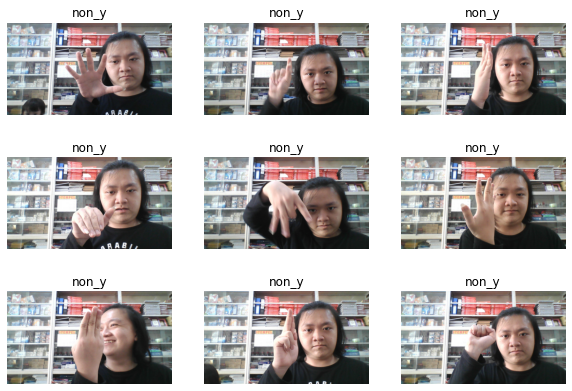

In [5]:
plt.figure(figsize=(10, 7))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [6]:
def crop_img(img):
    return img[:, :, (img_width//4):round(img_width * (1-.25)), :]

crop_layer = layers.Lambda(crop_img)

In [7]:
ANGLE = (-.8, .8)  # ANGLE * 2 * PI, 2*PI = 180deg

data_augmentation = keras.Sequential([
    layers.RandomRotation(ANGLE),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomZoom(height_factor=(-.2, .8), width_factor=(-.2, .8)),
    layers.RandomTranslation(height_factor=.26, width_factor=.26)
])


In [8]:
preprocess = keras.Sequential([crop_layer, data_augmentation])

In [9]:
def parse_landmark(hand_landmark):
    landmark = tuple((lm.x, lm.y, lm.z) for lm in hand_landmark.landmark)
    return np.array(landmark)

In [10]:
def images2landmarks(images: tf.TensorArray, **kwargs):
    with mp_hands.Hands(static_image_mode=True,
                        max_num_hands=1, 
                        min_detection_confidence=.7,
                        **kwargs) as hands:
        solutions = (hands.process(img.numpy().astype('uint8')) for img in images)
        landmarks = (s.multi_hand_landmarks for s in solutions)
        return [landmark[0] if landmark else None for landmark in landmarks]

In [11]:
def draw_landmark(image, hand, *args):
    mp_drawing.draw_landmarks(
        image,
        hand,
        mp_hands.HAND_CONNECTIONS,
        mp_drawing_styles.get_default_hand_landmarks_style(),
        mp_drawing_styles.get_default_hand_connections_style(), *args)


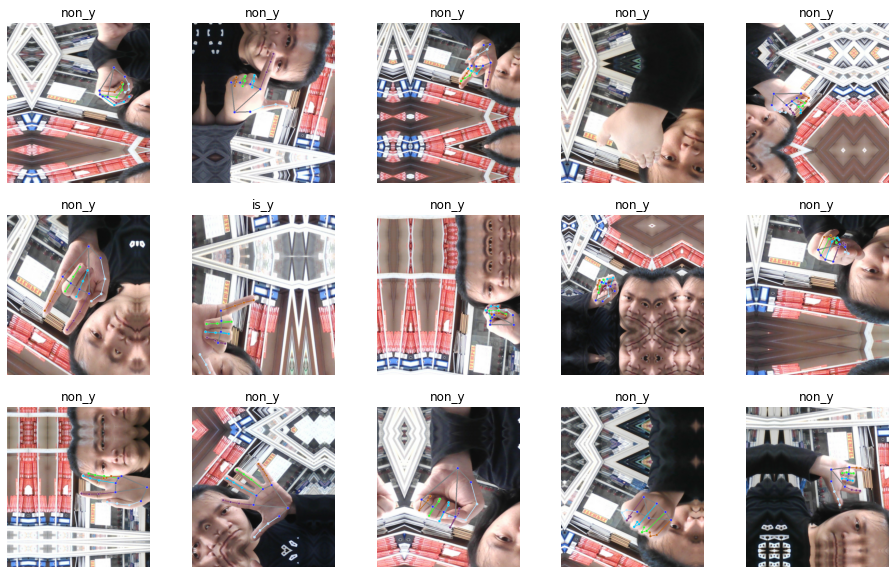

In [12]:
for images, labels in dataset.take(1):
    break

preprocessed_images = preprocess(images)
hands = images2landmarks(preprocessed_images)

plt.figure(figsize=(16, 10))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    img = preprocessed_images[i].numpy().astype('uint8').copy()
    if hands[i]:
        draw_landmark(img, hands[i])

    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_path = BASE_PATH/'data'
dataset_filepath = data_path/'landmark_ds_v2.csv'

In [14]:
try:
    landmark_df = pd.read_csv(dataset_filepath)
except FileNotFoundError:
    landmark_names = ('WRIST', 'THUMB_CMC', 'THUMB_MCP', 'THUMB_IP', 'THUMB_TIP',
       'INDEX_FINGER_MCP', 'INDEX_FINGER_PIP', 'INDEX_FINGER_DIP',
       'INDEX_FINGER_TIP', 'MIDDLE_FINGER_MCP', 'MIDDLE_FINGER_PIP',
       'MIDDLE_FINGER_DIP', 'MIDDLE_FINGER_TIP', 'RING_FINGER_MCP',
       'RING_FINGER_PIP', 'RING_FINGER_DIP', 'RING_FINGER_TIP',
       'PINKY_MCP', 'PINKY_PIP', 'PINKY_DIP', 'PINKY_TIP')
    columns = [f'{name}.{axis}' for name in landmark_names for axis in "XYZ"]
    landmark_df = pd.DataFrame([], columns=(*columns, 'IS_Y'))

print(f"Initial dataset contains {len(landmark_df.index)} rows")

Initial dataset contains 716 rows


In [15]:
EPOCH = 200

initial_len = len(landmark_df.index)
for ep in range(EPOCH):
    results = []
    for batch in dataset:
        images, labels = batch
        preprocessed_images = preprocess(images)
        hands = images2landmarks(preprocessed_images)
        for hand, label in zip(hands, labels.numpy()):
            if not hand:
                continue
            results.append((parse_landmark(hand), label))

    new_df = pd.DataFrame(([*lm.flatten(), class_names[label] == 'is_y']
                           for lm, label in results),
                          columns=landmark_df.columns)
    landmark_df = landmark_df.append(new_df)
    print(f"Added {len(new_df.index)} rows")

print(f"Finished adding {len(landmark_df.index) - initial_len} rows")

Added 718 rows
Added 702 rows
Added 727 rows
Added 719 rows
Added 726 rows
Added 723 rows
Added 712 rows
Added 731 rows
Added 709 rows
Added 723 rows
Added 713 rows
Added 724 rows
Added 722 rows
Added 725 rows
Added 720 rows
Added 719 rows
Added 730 rows
Added 713 rows
Added 709 rows
Added 721 rows
Added 708 rows
Added 727 rows
Added 719 rows
Added 731 rows
Added 700 rows
Added 710 rows
Added 726 rows
Added 709 rows
Added 707 rows
Added 715 rows
Added 709 rows
Added 711 rows
Added 723 rows
Added 732 rows
Added 709 rows
Added 718 rows
Added 716 rows
Added 728 rows
Added 721 rows
Added 720 rows
Added 711 rows
Added 727 rows
Added 716 rows
Added 722 rows
Added 724 rows
Added 713 rows
Added 711 rows
Added 714 rows
Added 727 rows
Added 730 rows
Added 707 rows
Added 727 rows
Added 721 rows
Added 716 rows
Added 721 rows
Added 722 rows
Added 710 rows
Added 706 rows
Added 710 rows
Added 719 rows
Added 733 rows
Added 706 rows
Added 723 rows
Added 720 rows
Added 714 rows
Added 736 rows
Added 718 

In [16]:
prev_len = len(landmark_df.index)
landmark_df.drop_duplicates(inplace=True)
current_len = len(landmark_df.index)
print(f"Removed {prev_len - current_len} duplicates")
print(f"Current dataset has {current_len} rows")

Removed 0 duplicates
Current dataset has 144372 rows


In [17]:
landmark_df.to_csv(dataset_filepath, index=None)